In [103]:
#Import necessary libraries

import numpy as np
import pandas as pd
import seal
from seal import *
import sourmash as smsh
import time
import matplotlib.pyplot as plt

In [2]:
#Load 8000 labelled samples, comprising training and test data
def load_data():
    with open("Challenge.fa", "r") as f:
        data = f.readlines()

    labels = []
    sequences = []
    lengths = []
    for k in range(len(data)):
        if k % 2 == 0:
            labels.append(data[k])
        else:
            seq = data[k].strip()
            lengths.append(len(seq))
            sequences.append(seq)

    # uniformize lengths by filling in with N's
    #max_length = max(lengths)
    #for i in range(len(sequences)):
        #padding_size = max_length - len(sequences[i])
        #for j in range(padding_size):
            #sequences[i] += "N"


    types = [">B.1.526", ">B.1.1.7", ">B.1.427", ">P.1"]

    dataframe = []

    for i in range(len(labels)):
        entry = []
        # 2021/08/02: re-replaced use of match-case (Python 3.10) for backwards compatibility
        for j in range(len(types)):
            if labels[i].startswith(types[j]):
                entry.append(j)
                virus_number = labels[i].split("_")[1].strip()
                entry.append(virus_number)
                entry.append(sequences[i])
                break

            if j == 3:
                raise "Bad entry"

        dataframe.append(entry)

    return dataframe

In [3]:
data = load_data()

In [144]:
data[4321]

[3,
 '3194',
 'AAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTTGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACA

In [5]:
data_df = pd.DataFrame(data)
labels = data_df[:][0]
labels

0       2
1       2
2       2
3       2
4       2
       ..
7995    0
7996    0
7997    0
7998    0
7999    0
Name: 0, Length: 8000, dtype: int64

In [6]:
base_dict = {0:'A',1:'C',2:'G',3:'T'}
base_dict

{0: 'A', 1: 'C', 2: 'G', 3: 'T'}

In [7]:
#Key preprocessing step:
#Replace all non-ACTG characters with an ACTG chosen uniformly at random.
start = time.time()
data_Nrand = []

for i in range(len(data)):
    string_mod = ''
    for j in range(len(data[i][2])):
        if data[i][2][j]=='A' or data[i][2][j]=='C' or data[i][2][j]=='G' or data[i][2][j]=='T':
            string_mod += data[i][2][j]
        else:
            string_mod+= base_dict[np.random.randint(0,4)]
    data_Nrand.append([data[i][0],data[i][1],string_mod])
    
end = time.time()
print(f'Time to Replace unknowns: {(end-start):.3f}s')
    
data_Nrand[4444]

Time to Replace unknowns: 118.468s


[3,
 '2029',
 'AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAA

In [8]:
#These are the sketch parameters that I settled on. Form sketches of all samples.
start = time.time()
sketches = []
N = 5000
K = 33

for i in range(len(data_Nrand)):
    mh = smsh.MinHash(n=N,ksize=K)
    mh.add_sequence(data_Nrand[i][2])
    sketches.append(mh)
    
end = time.time()
print(f'Time to form sketches: {(end-start):.3f}s')

Time to form sketches: 38.441s


In [9]:
#Set aside 1000 samples as test set held by data owner.
s= pd.Series(np.arange(8000))
test_samples = s.sample(n=1000, random_state = 101)
test_samples

7289    7289
5447    5447
5159    5159
3020    3020
1866    1866
        ... 
4280    4280
2146    2146
6111    6111
1724    1724
6194    6194
Length: 1000, dtype: int64

In [10]:
sketches_df = pd.DataFrame(sketches)
sketches_df.head()

,0
0,<sourmash.minhash.MinHash object at 0x7f22ccca...
1,<sourmash.minhash.MinHash object at 0x7f22f874...
2,<sourmash.minhash.MinHash object at 0x7f22ccd0...
3,<sourmash.minhash.MinHash object at 0x7f22ccca...
4,<sourmash.minhash.MinHash object at 0x7f22ccce...


In [11]:
test_sketches = sketches_df.iloc[list(test_samples)]
test_sketches.head()

,0
7289,<sourmash.minhash.MinHash object at 0x7f22cc95...
5447,<sourmash.minhash.MinHash object at 0x7f22cc97...
5159,<sourmash.minhash.MinHash object at 0x7f22cc96...
3020,<sourmash.minhash.MinHash object at 0x7f22cc9f...
1866,<sourmash.minhash.MinHash object at 0x7f22cca3...


In [12]:
test_indices = list(test_samples)
test_indices.sort(reverse=True)
test_indices

[7989,
 7987,
 7985,
 7970,
 7951,
 7934,
 7918,
 7915,
 7906,
 7902,
 7890,
 7888,
 7870,
 7863,
 7838,
 7832,
 7827,
 7826,
 7822,
 7819,
 7817,
 7814,
 7809,
 7807,
 7796,
 7795,
 7784,
 7776,
 7775,
 7774,
 7771,
 7770,
 7768,
 7765,
 7738,
 7730,
 7718,
 7704,
 7699,
 7690,
 7668,
 7667,
 7629,
 7627,
 7626,
 7620,
 7608,
 7595,
 7588,
 7581,
 7556,
 7533,
 7530,
 7502,
 7493,
 7492,
 7489,
 7483,
 7481,
 7455,
 7451,
 7445,
 7444,
 7432,
 7429,
 7423,
 7421,
 7392,
 7390,
 7369,
 7366,
 7364,
 7352,
 7346,
 7339,
 7333,
 7326,
 7322,
 7309,
 7291,
 7289,
 7280,
 7275,
 7266,
 7262,
 7260,
 7256,
 7255,
 7251,
 7250,
 7245,
 7241,
 7240,
 7210,
 7208,
 7204,
 7203,
 7181,
 7180,
 7175,
 7170,
 7169,
 7162,
 7147,
 7145,
 7136,
 7124,
 7111,
 7104,
 7095,
 7091,
 7072,
 7070,
 7051,
 6989,
 6988,
 6966,
 6960,
 6959,
 6954,
 6947,
 6945,
 6938,
 6932,
 6924,
 6917,
 6916,
 6915,
 6912,
 6907,
 6900,
 6892,
 6889,
 6886,
 6883,
 6876,
 6874,
 6868,
 6865,
 6863,
 6861,
 6858,
 6851,

In [13]:
#Hold test sketches aside from training set.
for i in range(len(test_indices)):
    sketches.pop(test_indices[i])

In [13]:
len(sketches)

7000

In [14]:
#Remove test labels
for i in range(len(test_indices)):
    labels.pop(test_indices[i])

In [15]:
labels

1       2
2       2
3       2
4       2
5       2
       ..
7995    0
7996    0
7997    0
7998    0
7999    0
Name: 0, Length: 7000, dtype: int64

In [16]:
#MODEL OWNER (TRAINING)
#Compute full matrix of Jaccard similarities. Takes a long time.
start = time.time()
jacc_sim = np.zeros((7000,7000))

for i in range(len(sketches)):
    #print(i)
    for j in range(i+1,len(sketches)):
        jacc_sim[i,j] = round(sketches[i].jaccard(sketches[j]),4)
        
end = time.time()
print(f'Time to compute similarities between all training sketches: {(end-start):.3f}s')

Time to compute similarities between all training sketches: 2320.965s


In [17]:
#Turn Jaccard similarities into matrix of distances.
start = time.time()
dist_adj = np.zeros((7000,7000))

for i in range(7000):
    #print(i)
    for j in range(i+1,7000):
        dist_adj[i,j] = -np.log(2*jacc_sim[i,j])+np.log(1+jacc_sim[i,j])
        dist_adj[j,i] = dist_adj[i,j]
        
end = time.time()
print(f'Time to compute training distances: {(end-start):.3f}s')

Time to compute training distances: 86.896s


In [18]:
dist_adj_df = pd.DataFrame(dist_adj)

In [19]:
from sklearn.model_selection import train_test_split

In [128]:
#Model is based on distances to 12 randomly chosen "anchor" samples
s = pd.Series(np.arange(7000))
anchors = s.sample(n=12,random_state=5)
anchors

4187    4187
5538    5538
141      141
9          9
5350    5350
27        27
4438    4438
3291    3291
735      735
960      960
40        40
5735    5735
dtype: int64

In [129]:
anchor_indices = list(anchors)

In [130]:
#Split Model Owner's samples into his own training and test set for validation
X_train, X_test, y_train, y_test = train_test_split(dist_adj_df[anchor_indices], np.ravel(labels), test_size=0.15, random_state=5)

In [23]:
from sklearn.linear_model import LogisticRegression

In [131]:
#MODEL OWNER (TRAINING)
#Fit a logistic regression model based on distances to anchors.
logmodel = LogisticRegression(fit_intercept=False)
logmodel.fit(X_train,y_train)

LogisticRegression(fit_intercept=False)

In [132]:
predictions = logmodel.predict(X_test)

In [133]:
predictions[:10]

array([3, 0, 2, 2, 0, 2, 3, 1, 2, 2])

In [134]:
#The 4*12 matrix of coefficients of the model. 
#This is the IP the Model Owner wishes to protect
logmodel.coef_

array([[  5.38405667, -15.02392849,   2.78022248,   2.04464006,
        -14.46495442,   3.0978776 ,   5.23952182,   7.89525877,
          3.26015033,   3.51521343,   1.99335128, -15.16965761],
       [  2.57595698,   3.36129094,   2.50847021,   2.72278128,
          2.79037976,   1.2513625 ,   3.9593228 , -26.3304838 ,
          1.26689735,   2.65378015,   2.02107092,   3.26273744],
       [  9.01096829,   7.17724818,  -9.40425647,  -8.64705352,
          6.57107627,  -8.11495679,   8.2612685 ,  10.87740952,
         -8.91658912,  -8.69388551,  -8.37992151,   7.11553559],
       [-16.97098195,   4.48538937,   4.11556379,   3.87963219,
          5.10349839,   3.76571669, -17.46011312,   7.55781551,
          4.38954143,   2.52489193,   4.36549931,   4.79138458]])

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

In [135]:
#Validate the model on a test set (not the Data Owner's test set)
print(confusion_matrix(y_test,predictions))

[[264   0   0   0]
 [  0 265   0   0]
 [  0   0 252   0]
 [  0   0   0 269]]


In [29]:
#Assume matr is mxn, where m divides n.
#Returns list of m vectors, each of which is a diagonal of length n.

def plain_diagonals(matr):
    m = matr.shape[0]
    n=matr.shape[1]
    vecs = np.zeros((m,n))
    for i in range(m):
        temp = []
        for j in range(n):
            k = j % m
            l = (j + i) % n
            temp.append(matr[k][l])
        vecs[i] = temp
    
    return vecs

In [136]:
#MODEL OWNER (offline phase)
#Convert matrix of coefficients into appropriate form for mat-vec product under HE
#And batch the coefficients to apply to multiple data samples at once
diags = plain_diagonals(logmodel.coef_)

batch_diags = np.zeros((4,8192))
for i in range(0,4):
    for j in range(0,341):
        batch_diags[i][24*j:24*j+12] = diags[i]
        
batch_diags[1][:48]

array([-15.02392849,   2.50847021,  -8.64705352,   5.10349839,
         3.0978776 ,   3.9593228 ,  10.87740952,   4.38954143,
         3.51521343,   2.02107092,   7.11553559, -16.97098195,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       -15.02392849,   2.50847021,  -8.64705352,   5.10349839,
         3.0978776 ,   3.9593228 ,  10.87740952,   4.38954143,
         3.51521343,   2.02107092,   7.11553559, -16.97098195,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [145]:
#DATA OWNER preprocessing
#Model owner sends data owner sketches of the anchor samples 
#Data owner computes vector of distances to each of the 12 anchors
#for each test sample.
#These vectors will be hidden by the encryption.
import time

start = time.time()
jacc_sim = np.zeros((1000,12))

i=0
for sketch in test_sketches[0]:
    for j in range(0,12):
        jacc_sim[i,j] = round(sketch.jaccard(sketches[anchor_indices[j]]),4)
    i+=1
        
dist_data = np.zeros((1000,12))

for i in range(1000):
    for j in range(12):
        dist_data[i,j] = -np.log(2*jacc_sim[i,j])+np.log(1+jacc_sim[i,j])
        
end = time.time()
print(f'Time to Preprocess Data: {(end-start):.3f}s')

Time to Preprocess Data: 1.494s


In [146]:
dist_data

array([[0.08634228, 0.01881707, 0.05289954, ..., 0.06595797, 0.05266646,
        0.01492718],
       [0.11833899, 0.13077683, 0.13656453, ..., 0.15005744, 0.13744011,
        0.12309729],
       [0.06716889, 0.08240152, 0.0881358 , ..., 0.08076136, 0.09006708,
        0.07588425],
       ...,
       [0.0864701 , 0.0171295 , 0.0516195 , ..., 0.06571627, 0.05266646,
        0.01430055],
       [0.08698183, 0.04746218, 0.02403763, ..., 0.0379478 , 0.02825017,
        0.04142919],
       [0.08113921, 0.01576448, 0.04746218, ..., 0.06187089, 0.04780677,
        0.00974034]])

In [147]:
#DATA OWNER preprocessing
#Batches 341 samples into a single plaintext (8192 slots / (12 + 12 empty))
#1000 samples are placed into 3 large vectors
#batch_data[2] has extra 0's at the end
batch_data = np.zeros((3,8192))
for i in range(3):
    for j in range(341):
        if 341*i+j < 1000:
            batch_data[i][24*j:24*j+12] = dist_data[341*i+j]
    
    
batch_data[2][-600:]

array([0.02350126, 0.0379478 , 0.02825017, 0.04142919, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08113921, 0.01576448, 0.04746218, 0.04335308,
       0.0145093 , 0.04941929, 0.06463062, 0.05336616, 0.04620154,
       0.06187089, 0.04780677, 0.00974034, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [34]:
#MODEL OWNER offline
#Important polynomial libraries
import numpy.polynomial.chebyshev as C
from numpy.polynomial import Polynomial as P

In [35]:
#MODEL OWNER offline
#This defines a degree 9 polynomial which is a good L-infinity approximation
#to a threshold function at .5 on the interval [-3,3]
#This has shown the best performance
approx = C.Chebyshev.interpolate(lambda x: .5*np.tanh(10*(x-.5))+.5,9,domain=[-3,3]).convert(kind=P)

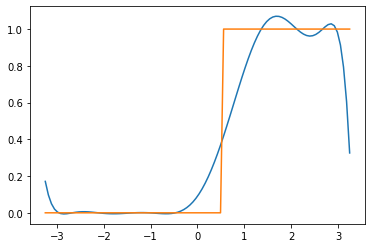

In [36]:
#A plot of approx
import matplotlib.pyplot as plt

x = np.linspace(-3.25,3.25,100)
ax = plt.plot(x, approx(x))

ax = plt.plot(x,np.heaviside(x-.5,.5))
plt.show()

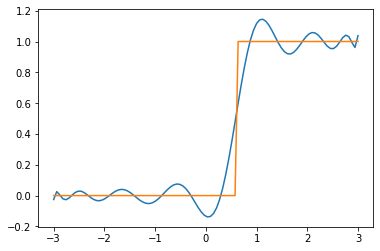

In [54]:
approx9 = C.Chebyshev.interpolate(lambda x: .5*np.tanh(20*(x-.6))+.5,15,domain=[-3,3]).convert(kind=P)

x = np.linspace(-3,3,100)
ax = plt.plot(x, approx9(x))

ax = plt.plot(x,np.heaviside(x-.6,.5))
plt.show()

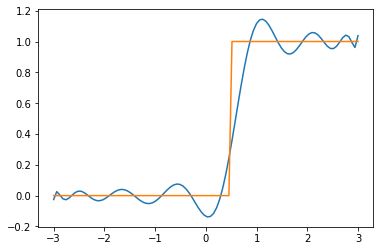

In [83]:
approx15 = C.Chebyshev.interpolate(lambda x: .5*np.tanh(20*(x-.5))+.5,15,domain=[-3,3]).convert(kind=P)

x = np.linspace(-3,3,100)
ax = plt.plot(x, approx15(x))

ax = plt.plot(x,np.heaviside(x-.5,.5))
plt.show()

In [38]:
#DATA OWNER
#Set the parameters of the encryption context.

parms = EncryptionParameters(scheme_type.ckks)
poly_modulus_degree = 16384
parms.set_poly_modulus_degree(poly_modulus_degree)
parms.set_coeff_modulus(CoeffModulus.Create(poly_modulus_degree, [60, 40, 40, 40, 40, 40, 60]))
#320-bit coeff modulus Q. 
#From SEAL manual, security cutoffs for N=16384 are 300 bits for 192-bit security, 438 bits for 128-bit security.
scale = 2.0**40
context = SEALContext(parms)
#print_parameters(context)

print(CoeffModulus.MaxBitCount(poly_modulus_degree))

ckks_encoder = CKKSEncoder(context)
slot_count = ckks_encoder.slot_count()
print(f'Number of slots: {slot_count}')

keygen = KeyGenerator(context)
public_key = keygen.create_public_key()
secret_key = keygen.secret_key()
galois_keys = keygen.create_galois_keys()
relin_keys = keygen.create_relin_keys()

encryptor = Encryptor(context, public_key)
evaluator = Evaluator(context)
#decryptor = Decryptor(context, secret_key)

438
Number of slots: 8192


In [39]:
def compute_logmodel_linear(ct_data,pt_diag_coeff,evaluator,galois_keys):
    #Copy the entries of ct_data into the next 12 slots so that rotation works properly
    ct_rot = evaluator.rotate_vector(ct_data, -12, galois_keys)
    ct_temp = evaluator.add(ct_data, ct_rot)


    #Evaluate pt-ct matrix-vector product.
    temp_result = evaluator.multiply_plain(ct_data,pt_diag_coeff[0])

    #pt_temp_result = decryptor.decrypt(temp_result)
    #print(ckks_encoder.decode(pt_temp_result)[:14])

    for i in range(1,4):
        temp_data_vec = evaluator.rotate_vector(ct_temp,i,galois_keys)
        evaluator.multiply_plain_inplace(temp_data_vec,pt_diag_coeff[i])
        evaluator.add_inplace(temp_result,temp_data_vec)
    

    evaluator.rescale_to_next_inplace(temp_result)
    #pt_temp_result = decryptor.decrypt(temp_result)
    #print(ckks_encoder.decode(pt_temp_result)[:14])

    temp_result1 = evaluator.rotate_vector(temp_result,4,galois_keys)
    temp_result2 = evaluator.rotate_vector(temp_result,8,galois_keys)

    result = evaluator.add_many([temp_result,temp_result1,temp_result2])
    
    return result

In [40]:
def threshold_poly(ct_score,poly_approx,evaluator,relin_keys):
    
    #ct_score is ciphertext of raw score results from linear part of the logistic regression model.
    #poly_approx is the np.array of coefficients of a degree 9 polynomial,
    #poly_approx[i] the coeff of x ** i
    
    #Hide raw scores and deliver only the category with max score.
    #Approximate max with polynomial approximation of threshold function.
    powers = []
    #const1 = [1]*slot_count
    #powers.append(encryptor.encrypt(ckks_encoder.encode(const1)))
    powers.append(ct_score)
    square = evaluator.square(ct_score)

    evaluator.relinearize_inplace(square,relin_keys)
    evaluator.rescale_to_next_inplace(square)
    powers.append(square)

    evaluator.mod_switch_to_next_inplace(powers[0])
    cube = evaluator.multiply(powers[0],powers[1])
    evaluator.relinearize_inplace(cube,relin_keys)
    evaluator.rescale_to_next_inplace(cube)
    powers.append(cube)

    sixth = evaluator.square(powers[2])
    evaluator.relinearize_inplace(sixth,relin_keys)
    evaluator.rescale_to_next_inplace(sixth)
    powers.append(sixth)

    #for power in powers:
        #print(f"Scale: {power.scale()}")

              
    #Encode coefficients of approximating polynomial in plaintext
    pt_coeff = []
    for i in range(len(poly_approx)):
        pt_coeff.append(ckks_encoder.encode(poly_approx[i],scale))

    #Evaluate polynomial in babystep-gianstep form.
    evaluator.mod_switch_to_inplace(pt_coeff[1],powers[0].parms_id())
    poly_term1 = evaluator.multiply_plain(powers[0],pt_coeff[1])
    evaluator.rescale_to_next_inplace(poly_term1)
    evaluator.mod_switch_to_inplace(pt_coeff[2],powers[1].parms_id())
    poly_term2 = evaluator.multiply_plain(powers[1],pt_coeff[2])
    evaluator.rescale_to_next_inplace(poly_term2)
    evaluator.mod_switch_to_inplace(pt_coeff[3],powers[2].parms_id())
    poly_term3 = evaluator.multiply_plain(powers[2],pt_coeff[3])
    evaluator.rescale_to_next_inplace(poly_term3)


    evaluator.mod_switch_to_inplace(poly_term1,poly_term3.parms_id())
    evaluator.mod_switch_to_inplace(poly_term2,poly_term3.parms_id())


    poly_term1.scale(poly_term3.scale())
    poly_term2.scale(poly_term3.scale())

    group1 = evaluator.add_many([poly_term1,poly_term2,poly_term3])
    evaluator.mod_switch_to_inplace(pt_coeff[0],group1.parms_id())
    pt_coeff[0].scale(group1.scale())
    evaluator.add_plain_inplace(group1,pt_coeff[0])


    evaluator.mod_switch_to_inplace(pt_coeff[4],powers[0].parms_id())
    poly_term4 = evaluator.multiply_plain(powers[0],pt_coeff[4])
    evaluator.rescale_to_next_inplace(poly_term4)
    evaluator.mod_switch_to_inplace(pt_coeff[5],powers[1].parms_id())
    poly_term5 = evaluator.multiply_plain(powers[1],pt_coeff[5])
    evaluator.rescale_to_next_inplace(poly_term5)
    evaluator.mod_switch_to_inplace(pt_coeff[6],powers[2].parms_id())
    poly_term6 = evaluator.multiply_plain(powers[2],pt_coeff[6])
    evaluator.rescale_to_next_inplace(poly_term6)

    evaluator.mod_switch_to_inplace(poly_term4,poly_term6.parms_id())
    evaluator.mod_switch_to_inplace(poly_term5,poly_term6.parms_id())


    poly_term4.scale(poly_term6.scale())
    poly_term5.scale(poly_term6.scale())

    group2 = evaluator.add_many([poly_term4,poly_term5,poly_term6])


    evaluator.mod_switch_to_inplace(pt_coeff[7],powers[0].parms_id())
    poly_term7 = evaluator.multiply_plain(powers[0],pt_coeff[7])
    evaluator.rescale_to_next_inplace(poly_term7)
    evaluator.mod_switch_to_inplace(pt_coeff[8],powers[1].parms_id())
    poly_term8 = evaluator.multiply_plain(powers[1],pt_coeff[8])
    evaluator.rescale_to_next_inplace(poly_term8)
    evaluator.mod_switch_to_inplace(pt_coeff[9],powers[2].parms_id())
    poly_term9 = evaluator.multiply_plain(powers[2],pt_coeff[9])
    evaluator.rescale_to_next_inplace(poly_term9)

    evaluator.mod_switch_to_inplace(poly_term7,poly_term9.parms_id())
    evaluator.mod_switch_to_inplace(poly_term8,poly_term9.parms_id())


    poly_term7.scale(poly_term9.scale())
    poly_term8.scale(poly_term9.scale())


    evaluator.mod_switch_to_inplace(powers[2],group2.parms_id())
    evaluator.multiply_inplace(group2,powers[2])
    evaluator.relinearize_inplace(group2,relin_keys)
    evaluator.rescale_to_next_inplace(group2)

    

    group3 = evaluator.add_many([poly_term7,poly_term8,poly_term9])
    evaluator.rescale_to_inplace(powers[3],group3.parms_id())
    evaluator.multiply_inplace(group3,powers[3])
    evaluator.relinearize_inplace(group3,relin_keys)
    evaluator.rescale_to_next_inplace(group3)

    

    evaluator.mod_switch_to_inplace(group1,group3.parms_id())
    evaluator.mod_switch_to_inplace(group2,group3.parms_id())

    
    group1.scale(group3.scale())
    group2.scale(group3.scale())

    final = evaluator.add_many([group1,group2,group3])
    
    return final

In [148]:
#ENCRYPTION, EVALUATION, DECRYPTION

start = time.time()


    
#DATA OWNER
#Encode and encrypt data owner's distance vector
pt_data = []
ct_data = []

for i in range(3):
    pt_data.append(ckks_encoder.encode(batch_data[i],scale))
    ct_data.append(encryptor.encrypt(pt_data[i]))

#MODEL OWNER
#HERE MODEL OWNER MUST RECEIVE ct_data, context, evaluator, galois_keys, and relin_keys
#Encode plaintext vectors
pt_model_diags = []
for i in range(0,diags.shape[0]):
    pt_model_diags.append(ckks_encoder.encode(batch_diags[i],scale))

#Model owner runs the encrypted calculation
final = []
for i in range(3):
    #Linear mat-vec product between model matrix and data
    result = compute_logmodel_linear(ct_data[i],pt_model_diags,evaluator, galois_keys)

    #Apply polynomial to approximate 0/1 classification vector
    final.append(threshold_poly(result,approx.coef,evaluator,relin_keys))

#evaluator.rescale_to_next_inplace(final)

#DATA OWNER
#Data owner receives final from Model Owner
pt_final = []
final_scores = []
decryptor = Decryptor(context, secret_key)
for i in range(3):
    pt_final.append(decryptor.decrypt(final[i]))
    final_scores.append(ckks_encoder.decode(pt_final[i]))

#pt_result = decryptor.decrypt(result)
#raw_scores = ckks_encoder.decode(pt_result)

#print(raw_scores)
end = time.time()
print(f'Time to Encrypt, Evaluate, and Decrypt: {(end-start):.3f}s')




Time to Encrypt, Evaluate, and Decrypt: 1.614s


In [149]:
#DATA OWNER postprocessing of results
#The first 4 entries of scores are the correct entries of the matrix-vector product. 
final_junk_removed = []
for j in range(1000):
    final_junk_removed.append(final_scores[j // 341][24*(j%341):24*(j%341)+4])
    
final_junk_removed

[array([ 1.01398046e+00,  4.45056908e-02, -2.35630066e-04, -4.23375650e-03]),
 array([0.00112107, 0.09911908, 0.00108734, 0.96778684]),
 array([-0.00329348,  0.06023261, -0.00237234,  1.06345896]),
 array([ 2.11553895e-02,  9.77594340e-01, -8.08867450e-04, -3.71023006e-03]),
 array([ 3.53754506e-02,  2.69765686e-02,  1.01777178e+00, -6.91092623e-04]),
 array([ 1.61305363e-02,  9.85288789e-01,  1.88341526e-04, -3.73376385e-03]),
 array([-7.46334399e-04,  2.87789428e-02, -2.56594476e-03,  1.01366541e+00]),
 array([ 0.01877886,  0.99199235, -0.00261873, -0.00295811]),
 array([-9.44142082e-04,  2.16420688e-02,  1.06510660e+00, -2.92659410e-03]),
 array([ 0.02415298,  1.06177205, -0.00501164, -0.00500458]),
 array([ 1.06636155,  0.02319921, -0.00354316, -0.00369778]),
 array([-0.00158533,  0.02340933,  1.06424961, -0.00310546]),
 array([8.89379884e-03, 2.12493944e-02, 1.07003861e+00, 4.96091424e-04]),
 array([ 0.00219263,  1.06568558, -0.00492917, -0.00299878]),
 array([-0.00436488,  0.0431

In [87]:
np.round(final_junk_removed)[:10]

array([[ 1.,  0., -0.,  0.],
       [ 0.,  0., -0.,  1.],
       [-0.,  0., -0.,  1.],
       [ 0.,  1., -0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1., -0.,  0.],
       [-0.,  0., -0.,  1.],
       [ 0.,  1., -0.,  0.],
       [-0., -0.,  1.,  0.],
       [ 0.,  1., -0.,  0.]])

In [71]:
#DATA OWNER postprocessing
#Very simple function to convert final_junk_removed to list of label predictions
#Correct conversion assumes all scores in final_junk_removed round to 0 or 1
#Could update function to change scores >1.5 to 0 and <-.5 to 1
#This version miscategorizes all 0's as belonging to the 0th category
#and if more than one category has a 1, the reported category is the sum.
def conv_to_pred(score_array):
    predictions = []
    for scores in score_array:
        predictions.append(int(np.dot(np.round(scores),np.array([0,1,2,3]))))
        
    return predictions

In [150]:
pred = conv_to_pred(final_junk_removed)

In [151]:
test_labels = data_df.loc[list(test_samples),0]

In [152]:
print(confusion_matrix(pred,test_labels))

[[256   0   0   0]
 [  0 236   0   0]
 [  0   0 250   0]
 [  0   0   0 258]]
